Notes on tutorial: <https://pytorch.org/rl/stable/tutorials/multiagent_ppo.html>

In [1]:
# Torch
import torch

# Tensordict modules
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# Devices
device = torch.device(0)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 6_000  # Number of team frames collected per training iteration
n_iters = 10  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 30  # Number of optimization steps per training iteration
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.2  # clip value for PPO loss
gamma = 0.99  # discount factor
lmbda = 0.9  # lambda for generalised advantage estimation
entropy_eps = 1e-4  # coefficient of the entropy term in the PPO loss

In [3]:
max_steps = 100  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "navigation"
n_agents = 3

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)

In [4]:
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

action_spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([60, 3])),
    device=cuda:0,
    shape=torch.Size([60]))
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([60, 3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
           

In [5]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


In [6]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

In [7]:
check_env_specs(env)

/home/endoplasm/develop/torchrl-mlagents/torchrl/envs/common.py:998: DeprecationWarning: You are querying a non-trivial, single reward_spec, i.e., there is only one reward known by the environment but it is not named `'reward'`. Currently, env.reward_spec returns the leaf but for consistency with the setter, this will return the full spec instead (from v0.8 and on).
  warnings.warn(
2024-11-22 18:28:08,153 [torchrl][INFO] check_env_specs succeeded!


In [8]:
n_rollout_steps = 6
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 6, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([60, 6, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 6, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        final_rew: Tensor(shape=torch.Size([60, 6, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        pos_rew: Tensor(shape=torch.Size([60, 6, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                    batch_size=torch.Size([60, 6, 3]),
                    device=cuda:0,
                    is_shared=True),
                observation: Tensor(shape=torch.Size([60, 6, 3, 18]), device=cud

In [9]:
share_parameters_policy = True

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=env.observation_spec["agents", "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=2 * env.action_spec.shape[-1],  # 2 * n_actions_per_agents
        n_agents=env.n_agents,
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)

/home/endoplasm/develop/torchrl-mlagents/torchrl/envs/common.py:783: DeprecationWarning: You are querying a non-trivial, single action_spec, i.e., there is only one action known by the environment but it is not named `'action'`. Currently, env.action_spec returns the leaf but for consistency with the setter, this will return the full spec instead (from v0.8 and on).
  warnings.warn(


In [10]:
env.n_agents

3

In [11]:
env.unbatched_action_spec

/home/endoplasm/develop/torchrl-mlagents/torchrl/envs/libs/vmas.py:374: UserWarning: unbatched_action_spec is deprecated and will be removed in v0.9. Please use full_action_spec_unbatched instead.
  warnings.warn(


Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([3])),
    device=cuda:0,
    shape=torch.Size([]))

In [12]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

In [13]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.unbatched_action_spec,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.unbatched_action_spec[env.action_key].space.low,
        "high": env.unbatched_action_spec[env.action_key].space.high,
    },
    return_log_prob=True,
    log_prob_key=("agents", "sample_log_prob"),
)  # we'll need the log-prob for the PPO loss

In [14]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=env.observation_spec["agents", "observation"].shape[-1],
    n_agent_outputs=1,  # 1 value per agent
    n_agents=env.n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[("agents", "observation")],
    out_keys=[("agents", "state_value")],
)

In [15]:
print("Running policy:", policy(env.reset()))
print("Running value:", critic(env.reset()))

Running policy: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                info: TensorDict(
                    fields={
                        agent_collisions: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        final_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        pos_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
                    batch_size=torch.Size([60, 3]),
                    device=cuda:0,
                    is_shared=True),
                loc: Tensor(shape=torch.Size([60, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=Tr

In [16]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [17]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

In [18]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    sample_log_prob=("agents", "sample_log_prob"),
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

In [19]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = 2.7639410495758057: 100%|██████████| 10/10 [00:47<00:00,  4.95s/it] 

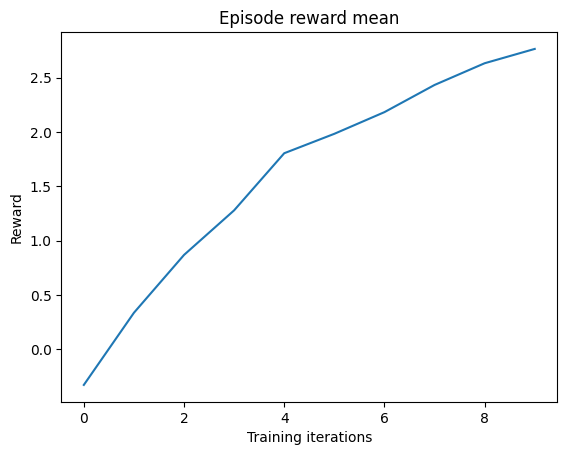

In [20]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

In [21]:
env.reset()

with torch.no_grad():
   env.rollout(
       max_steps=2*max_steps,
       policy=policy,
       callback=lambda e, _: e.render(),
       auto_cast_to_device=True,
       break_when_any_done=False,
       break_when_all_done=False,
   )